In [1]:
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform
from keras.utils.np_utils import to_categorical

测试集 训练集 label

In [2]:
train_label  = pd.read_excel('./dataset/train.xlsx', engine='openpyxl', sheet_name="Sheet1")
test_label = pd.read_excel('./dataset/test.xlsx', engine='openpyxl', sheet_name="Sheet1")

# 循环方案  
窗格长度3s 步长1s  

循环方案+投票表决  
解决长度不一致问题


In [3]:
fs = 16000
window = 3
step = 1
path = './dataset/train/'

In [4]:
class Generate_data():
    def __init__(self, path, train_label, split_rate=0.2, random_state=1, window=3, step=1, fs=16000):
        self.path = path
        self.train_label = train_label
        self.split_rate = split_rate
        self.random_state = random_state
        self.window = window
        self.step = step
        self.fs = fs
        self.random_state = random_state
    
    # def get_subsig(self, label, filename, sig, fs=self.fs, window=self.window, step=self.step):
    def get_subsig(self, label, filename, sig):
        subsig_len = np.ceil(sig.shape[0]/(self.step * self.fs)).astype('int') - (self.window - self.step)
        window_size = self.fs * self.window
        step_size = self.fs * self.step
        
        dataset = []
        for i in range(subsig_len):
            subsig = sig[i*step_size: i*step_size+window_size]
            if i == subsig_len - 1:
                subsig = np.concatenate((subsig,sig[0:window_size-len(subsig)]), axis=0)
            dataset.append({'label': label, 'filename': filename, 'segement':i+1, 'sig': subsig})

        return dataset

    def get_dataset(self, data_pd):
        dataset = []
        for _, line in tqdm(data_pd.iterrows()):
            sig, _ = librosa.load(path+'{}'.format(line['filename']), sr=fs)
            label = line['label']
            dataset += self.get_subsig(label=label, filename=line['filename'], sig=sig)
        return dataset


    def get_Train_Test(self):
        Train_pd, Test_pd = train_test_split(self.train_label, test_size=self.split_rate, random_state=self.random_state)
        self.Train_dataset = self.get_dataset(Train_pd)
        self.Test_dataset = self.get_dataset(Test_pd)
        return self.Train_dataset, self.Test_dataset

In [5]:
dataset = Generate_data(path=path, train_label=train_label, split_rate=0.2, random_state=1, window=3, step=1, fs=16000)
Train, Test = dataset.get_Train_Test()

1600it [00:05, 275.00it/s]
400it [00:01, 290.40it/s]


# 特征构造

In [6]:
class feature_engine():
    def __init__(self, dataset):
        self.dataset = dataset
        self.fs = fs
    
    def get_feature(self, sig):
        n_mels=80
        melspec = librosa.feature.melspectrogram(sig, sr=self.fs, n_fft=1024, hop_length=512, n_mels=80)
        logmelspec = librosa.power_to_db(melspec)
        return logmelspec.reshape(n_mels, -1, 1)
    
    def get_XY(self):
        X_train = []
        Y_train = []

        for item in tqdm(self.dataset):
            Y_train.append(item['label'])
            X_train.append(self.get_feature(item['sig']))
        
        self.X = np.array(X_train)
        self.Y = to_categorical(np.array(Y_train).reshape(-1, 1), 2)
    
    def save_train(self, name):
        np.save('{}_X'.format(name), self.X)
        np.save('{}_Y'.format(name), self.Y)

In [7]:
Train_feature = feature_engine(Train)
Test_feature = feature_engine(Test)

Train_feature.get_XY()
Test_feature.get_XY()

100%|███████████████████████████████████████████████████████████████████████████████| 732/732 [00:01<00:00, 449.71it/s]


In [8]:
Train_feature.Y.sum(axis=0)

array([ 934., 2150.], dtype=float32)

In [9]:
Test_feature.Y.sum(axis=0)

array([226., 506.], dtype=float32)

# 模型结构

模型设计  
监督学习分类器  

输入：序列（length:`window*fs`）  
输出：0 or 1

In [10]:
tf.test.gpu_device_name()  # test if GPU is availabe. GPU will be much faster. 
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12229938113272571898,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5736300544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9940428781311994664
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [11]:
# def identity_block(X, f, filters, stage, block):
 
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'
 
#     F1, F2, F3 = filters
 
#     X_shortcut = X
 
#     X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed = 0))(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
#     X = Activation('relu')(X)
 
#     X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0))(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
#     X = Activation('relu')(X)
 
#     X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0))(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
 
#     return X

# def convolution_block(X, f, filters, stage, block, s=2):
 
#     conv_name_base = 'res' + str(stage) + block + '_branch'
#     bn_name_base = 'bn' + str(stage) + block + '_branch'
#     F1, F2, F3 = filters
 
#     X_shortcut = X
 
#     X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed = 0))(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
#     X = Activation('relu')(X)
 
#     X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0))(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
#     X = Activation('relu')(X)
 
#     X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0))(X)
#     X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
#     X_shortcut = Conv2D(F3, (1,1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
#     X_shortcut = BatchNormalization(axis = 3, name=bn_name_base + '1')(X_shortcut)
 
#     X = Add()([X, X_shortcut])
#     X = Activation('relu')(X)
 
#     return X

# def my_model(input_shape = (80, 94, 1), classes = 2):
 
#     X_input = Input(input_shape)
#     # conv1
#     X = ZeroPadding2D((3, 3))(X_input)
#     X = Conv2D(64, (7, 7), strides = (2,2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
#     X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
#     X = Activation('relu')(X)
#     X = MaxPooling2D((3, 3), strides = (2,2))(X)
#     # basicblock1
#     X = convolution_block(X, f = 3, filters = [64,64,256], stage = 2, block = 'a', s = 1)
#     X = Dropout(0.2)(X)
#     X = identity_block(X, 3, [64,64,256], stage=2, block='b')
#     X = Dropout(0.2)(X)
#     X = identity_block(X, 3, [64,64,256], stage=2, block='c')
#     X = Dropout(0.2)(X)
    
# #     X = convolution_block(X, f = 3, filters = [128,128,512], stage = 3, block = 'a', s = 2)
# #     X = Dropout(0.2)(X)
# #     X = identity_block(X, 3, [128,128,512], stage=3, block='b')
# #     X = Dropout(0.2)(X)
# #     X = identity_block(X, 3, [128,128,512], stage=3, block='c')
# #     X = Dropout(0.2)(X)
# #     X = identity_block(X, 3, [128,128,512], stage=3, block='d')
 
# #     X = convolution_block(X, f = 3, filters = [256,256,1024], stage = 4, block = 'a', s = 2)
# #     X = Dropout(0.2)(X)
# #     X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
# #     X = Dropout(0.2)(X)
# #     X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
# #     X = Dropout(0.2)(X)
# #     X = identity_block(X, 3, [256,256,1024], stage=4, block='d')    
# #     X = Dropout(0.2)(X)
# #     X = identity_block(X, 3, [256,256,1024], stage=4, block='e')
# #     X = Dropout(0.2)(X)
# #     X = identity_block(X, 3, [256,256,1024], stage=4, block='f')
 
# #     X = convolution_block(X, f = 3, filters = [512,512,2048], stage = 5, block = 'a', s = 2)
# #     X = Dropout(0.2)(X)
# #     X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
# #     X = Dropout(0.2)(X)
# #     X = identity_block(X, 3, [512,512,2048], stage=5, block='c')
 
#     X = AveragePooling2D((2, 2), name='avg_pool')(X)
 
#     X = Flatten()(X)
#     X = Dense(classes, activation = 'softmax', name = 'fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
 
#     model = Model(inputs = X_input, outputs = X, name = 'my_model')
#     model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
    
#     return model

In [12]:
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D

# 继承Layer,建立resnet18和34卷积层模块
class CellBlock(layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(CellBlock, self).__init__()

        self.conv1 = Conv2D(filter_num, (3,3), strides=stride, padding='same')
        self.bn1 = BatchNormalization()
        self.relu = Activation('relu')

        self.conv2 = Conv2D(filter_num, (3,3), strides=1, padding='same')
        self.bn2 = BatchNormalization()

        if stride !=1:
            self.residual = Conv2D(filter_num, (1,1), strides=stride)
        else:
            self.residual = lambda x:x
        
    def call (self, inputs, training=None):

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        r = self.residual(inputs)

        x = layers.add([x, r])
        output = tf.nn.relu(x)

        return output

#继承Model， 创建resnet18和34
class ResNet(models.Model):
    def __init__(self, layers_dims, nb_classes):
        super(ResNet, self).__init__()

        self.stem = Sequential([
            Conv2D(64, (7,7), strides=(2,2),padding='same'),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D((3,3), strides=(2,2), padding='same')
        ]) #开始模块

        self.layer1 = self.build_cellblock(64, layers_dims[0]) 
        self.layer2 = self.build_cellblock(128, layers_dims[1], stride=2)
        self.layer3 = self.build_cellblock(256, layers_dims[2], stride=2)
        self.layer4 = self.build_cellblock(512, layers_dims[3], stride=2)

        self.avgpool = GlobalAveragePooling2D()
        self.fc = Dense(nb_classes, activation='softmax')
    
    def call(self, inputs, training=None):
        x=self.stem(inputs)
        # print(x.shape)

        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        
        x=self.avgpool(x)
        x=self.fc(x)

        return x

    def build_cellblock(self, filter_num, blocks, stride=1):
        res_blocks = Sequential()
        res_blocks.add(CellBlock(filter_num, stride)) #每层第一个block stride可能为非1

        for _ in range(1, blocks):      #每一层由多少个block组成
            res_blocks.add(CellBlock(filter_num, stride=1))

        return res_blocks


def build_ResNet(NetName, nb_classes):
    ResNet_Config = {'ResNet18':[2,2,2,2], 
                    'ResNet34':[3,4,6,3]}

    return ResNet(ResNet_Config[NetName], nb_classes) 


In [13]:
np.random.seed(40)
model = build_ResNet('ResNet18', 2)
model.build(input_shape=(None, 80, 94, 1))
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 20, 24, 64)        3456      
_________________________________________________________________
sequential_1 (Sequential)    (None, 20, 24, 64)        148736    
_________________________________________________________________
sequential_2 (Sequential)    (None, 10, 12, 128)       526976    
_________________________________________________________________
sequential_3 (Sequential)    (None, 5, 6, 256)         2102528   
_________________________________________________________________
sequential_4 (Sequential)    (None, 3, 3, 512)         8399360   
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1026

In [14]:
epoch=82
batch_size=64
class_weights = 1/Train_feature.Y.sum(axis=0)*Train_feature.Y.sum()/2
class_weights = {0:class_weights[0], 1:class_weights[1]}
history1 = model.fit(Train_feature.X, Train_feature.Y, 
                     batch_size=batch_size, epochs=epoch, verbose=1, 
                     validation_split=0.2, validation_steps=(int(0.2*len(Train_feature.X)) // batch_size), 
                     class_weight=class_weights, shuffle=True)

Epoch 1/82
39/39 [==============================] - 19s 44ms/step - loss: 0.4904 - accuracy: 0.8581 - val_loss: 8.9422 - val_accuracy: 0.3733
Epoch 2/82
39/39 [==============================] - 1s 28ms/step - loss: 0.1737 - accuracy: 0.9291 - val_loss: 2.4242 - val_accuracy: 0.3733
Epoch 3/82
39/39 [==============================] - 1s 28ms/step - loss: 0.0554 - accuracy: 0.9838 - val_loss: 1.2879 - val_accuracy: 0.6562
Epoch 4/82
39/39 [==============================] - 1s 28ms/step - loss: 0.0525 - accuracy: 0.9801 - val_loss: 0.1917 - val_accuracy: 0.9323
Epoch 5/82
39/39 [==============================] - 1s 28ms/step - loss: 0.0374 - accuracy: 0.9846 - val_loss: 0.1529 - val_accuracy: 0.9392
Epoch 6/82
39/39 [==============================] - 1s 28ms/step - loss: 0.0676 - accuracy: 0.9809 - val_loss: 0.1970 - val_accuracy: 0.9358
Epoch 7/82
39/39 [==============================] - 1s 30ms/step - loss: 0.0303 - accuracy: 0.9882 - val_loss: 0.8307 - val_accuracy: 0.8403
Epoch 8/82
3

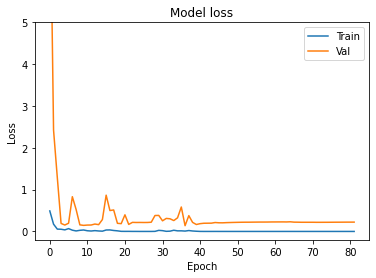

In [15]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.ylim(-0.2, 5)
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('loss_res18.jpg')
plt.show()

In [16]:
max(history1.history['val_accuracy'])

0.9670138955116272

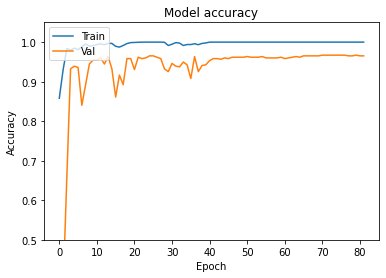

In [17]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.05)
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('accuracy_res18.jpg')
plt.show()

# 测试集检验

In [18]:
def sub_devote(filename, sig, fs=16000, window=3, step=1):
        subsig_len = np.ceil(sig.shape[0]/(step * fs)).astype('int') - (window - step)
        window_size = fs * window
        step_size = fs * step
        
        dataset = []
        for i in range(subsig_len):
            subsig = sig[i*step_size: i*step_size+window_size]
            if i == subsig_len - 1:
                subsig = np.concatenate((subsig,sig[0:window_size-len(subsig)]), axis=0)
            dataset.append(subsig)
        return dataset

def get_feature(sig):
        n_mels=80
        melspec = librosa.feature.melspectrogram(sig, sr=fs, n_fft=1024, hop_length=512, n_mels=80)
        logmelspec = librosa.power_to_db(melspec)
        return logmelspec.reshape(n_mels, -1, 1)

def clasify(sequence, filename, sig, window=window, step=step):
    predict_data = sub_devote(filename=filename, sig=sig, window=window, step=step)
    maps = np.array([get_feature(sequencei) for sequencei in predict_data])
    results = np.argmax(model.predict(maps), axis=1)
    
    if results.mean()>0.5:
        return 1
    else:
        return 0

In [19]:
test_Pred = []
for line in tqdm(Test):
    sig = line['sig']
    predict_label = clasify(sig, filename=line['filename'], sig=sig, window=window, step=step)
    test_Pred.append(predict_label)

100%|████████████████████████████████████████████████████████████████████████████████| 732/732 [00:29<00:00, 24.89it/s]


In [124]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

classes=['Woman', 'Man']
print(classification_report(Test_feature.Y.argmax(axis=1), test_Pred, target_names=classes, digits=4))

              precision    recall  f1-score   support

       Woman     0.9774    0.9558    0.9664       226
         Man     0.9804    0.9901    0.9853       506

    accuracy                         0.9795       732
   macro avg     0.9789    0.9729    0.9758       732
weighted avg     0.9795    0.9795    0.9794       732



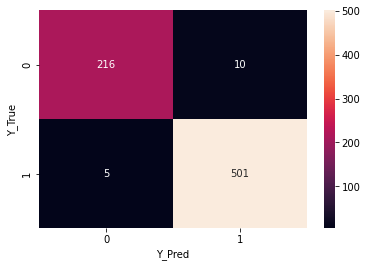

In [21]:
cm = confusion_matrix(Test_feature.Y.argmax(axis=1), test_Pred)
sns.heatmap(cm, annot=True, fmt='.20g')
plt.xlabel('Y_Pred')
plt.ylabel('Y_True')
plt.savefig('confusion.jpg')

# 预测结果

In [22]:
result = []
for _, line in tqdm(test_label.iterrows()):
    sig, _ = librosa.load('./dataset/test/{}'.format(line['filename']), sr=fs)
    # model predict
    predict_label = clasify(sig, filename=line['filename'], sig=sig, window=window, step=step)
    result.append([line['filename'], predict_label])
result = pd.DataFrame(result, columns=['filename', 'label'])
result.to_excel('result.xlsx', index=False)

500it [00:21, 23.45it/s]


# PA

In [133]:
sig, _ = librosa.load('test3.wav', sr=fs)
    # model predict
predict_label = clasify(sig, filename=line['filename'], sig=sig, window=window, step=step)

In [134]:
predict_label

1

In [45]:
import librosa.display

D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26446 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21018 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 26446 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29577 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 21018 missing from curre

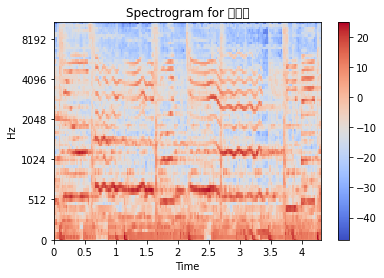

In [130]:
sig, _ = librosa.load('test1.wav', sr=fs)
melspec = librosa.feature.melspectrogram(sig, sr=fs, n_fft=1024, hop_length=512, n_mels=80)
logmelspec = librosa.power_to_db(melspec)
librosa.display.specshow(logmelspec, y_axis='mel', x_axis='time');
plt.title('Spectrogram for 李玉刚');
plt.colorbar();

plt.savefig('李玉刚.png')

D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21608 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 28145 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 21608 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 28145 missing from current font.
  font.set_text(s, 0, flags=flags)


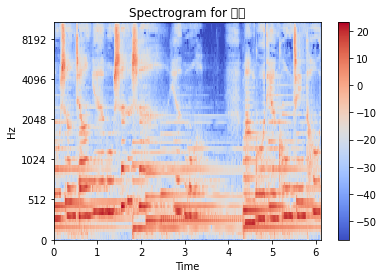

In [131]:
sig, _ = librosa.load('test2.wav', sr=fs)
melspec = librosa.feature.melspectrogram(sig, sr=fs, n_fft=1024, hop_length=512, n_mels=80)
logmelspec = librosa.power_to_db(melspec)
librosa.display.specshow(logmelspec, y_axis='mel', x_axis='time');
plt.title('Spectrogram for 周深');
plt.colorbar();

plt.savefig('周深.png')

D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 28504 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 20521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 28504 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\miniconda\envs\sounds\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 20521 missing from current font.
  font.set_text(s, 0, flags=flags)


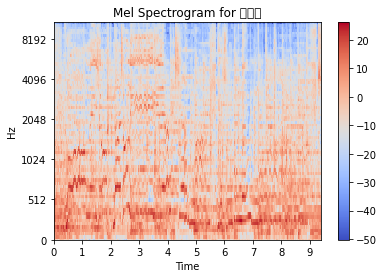

In [132]:
sig, _ = librosa.load('test3.wav', sr=fs)
melspec = librosa.feature.melspectrogram(sig, sr=fs, n_fft=1024, hop_length=512, n_mels=80)
logmelspec = librosa.power_to_db(melspec)
librosa.display.specshow(logmelspec, y_axis='mel', x_axis='time');
plt.title('Mel Spectrogram for 潘倩倩');
plt.colorbar();

plt.savefig('潘倩倩.png')

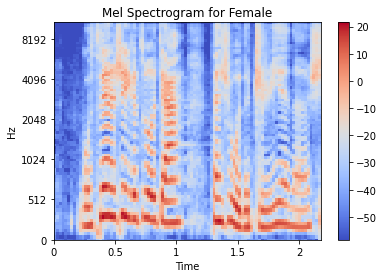

In [122]:
librosa.display.specshow(Train_feature.X[7].reshape(80, -1), y_axis='mel', x_axis='time');


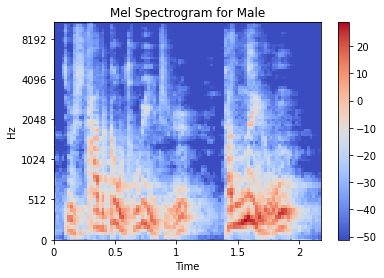

In [121]:
librosa.display.specshow(Train_feature.X[4].reshape(80, -1), y_axis='mel', x_axis='time');
plt.title('Mel Spectrogram for Male');
plt.colorbar();

plt.savefig('mel_trainM.png')